In [91]:
%matplotlib inline

import stumpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
%load_ext autoreload
%autoreload 2

import datetime as dt
import dtale
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
from darts import TimeSeries

import wrangle as wg
import scipy.stats as stats
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 
# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt
from statsmodels.tsa.arima.model import ARIMA

plt.rcParams["figure.figsize"] = [20,6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = wg.get_dow()
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


In [3]:
df = wg.prep_DOW(df)
df.head()

,stock,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
date,,,,,,,,,,,,,,
2011-01-04,IBM,161.54,164.42,161.12,164.27,19081936,1.68998,-24.820375,25381792.0,164.42,164.05,-0.225033,35,0.456565
2011-01-04,TRV,59.09,60.01,58.37,59.71,16608737,1.04925,17.569654,14126721.0,59.83,59.58,-0.417851,68,0.686652
2011-01-04,KO,65.20,67.48,65.03,67.22,39265955,3.09816,31.529107,29853434.0,67.22,67.27,0.074383,73,0.699197
2011-01-04,XOM,83.86,84.94,82.61,84.68,77569311,0.97782,-6.951645,83364516.0,84.26,85.95,2.005700,40,0.555031
2011-01-04,PG,61.08,62.30,60.61,62.08,43453701,1.63720,5.084613,41351155.0,62.17,61.90,-0.434293,26,0.853737


In [4]:
# top 1 for price of stock / # 2 for percent change mean
df_ibm = df.where(df['stock'] == 'IBM')
df_ibm = df_ibm.dropna()

# top 1 for % change mean
df_pfe = df.where(df['stock'] == 'PFE')
df_pfe = df_pfe.dropna()

# top 1 for volume
df_bac = df.where(df['stock'] == 'BAC')
df_bac = df_bac.dropna()


# frankly, not enough data was in this DF but alas, we'll see how it goes
df_ibm.shape, df_pfe.shape, df_bac.shape

((25, 14), (25, 14), (25, 14))

In [5]:
df_resampled = df_ibm.resample('w')[['percent_change_price','close','open']].sum()

In [6]:
df_resampled.head()

,percent_change_price,close,open
date,,,
2011-01-09,1.68998,164.27,161.54
2011-01-16,2.04082,150.00,147.00
2011-01-23,3.79122,155.50,149.82
2011-01-30,2.43855,159.21,155.42
2011-02-06,0.00000,0.00,0.00


In [7]:
df_resampled.shape

(44, 3)

In [8]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

22

In [9]:
# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

13

In [10]:
# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

9

In [11]:
len(df_resampled) == train_size + validate_size + test_size

True

In [12]:

validate_end_index = train_size + validate_size
validate_end_index

35

In [13]:
train = df_resampled[:train_size]

In [14]:
validate = df_resampled[train_size:validate_end_index]

In [15]:
train.tail()

,percent_change_price,close,open
date,,,
2011-05-08,0.000000,0.00,0.00
2011-05-15,0.908605,169.92,168.39
2011-05-22,0.206113,170.16,169.81
2011-05-29,-0.593472,167.50,168.50
2011-06-05,-1.870900,168.89,172.11


In [16]:
validate.head()

,percent_change_price,close,open
date,,,
2011-06-12,0.000000,0.00,0.00
2011-06-19,0.000000,164.44,164.44
2011-06-26,0.836897,165.07,163.70
2011-07-03,0.489097,147.93,147.21
2011-07-10,0.000000,0.00,0.00


In [17]:
validate.tail()

,percent_change_price,close,open
date,,,
2011-08-07,-0.225033,164.05,164.42
2011-08-14,0.000000,0.00,0.00
2011-08-21,0.000000,0.00,0.00
2011-08-28,0.000000,0.00,0.00
2011-09-04,0.000000,0.00,0.00


In [18]:
test = df_resampled[validate_end_index:]

In [19]:
train.shape[0], validate.shape[0], test.shape[0]

(22, 13, 9)

In [20]:
len(train) + len(validate) + len(test) == len(df_resampled)

True

In [21]:
print(df_resampled.head(1) == train.head(1))

            percent_change_price  close  open
date                                         
2011-01-09                  True   True  True


In [22]:
pd.concat([train.tail(1), validate.head(1)])

,percent_change_price,close,open
date,,,
2011-06-05,-1.8709,168.89,172.11
2011-06-12,0.0000,0.00,0.00


In [23]:
pd.concat([validate.tail(1), test.head(1)])

,percent_change_price,close,open
date,,,
2011-09-04,0.0,0.0,0.0
2011-09-11,0.0,0.0,0.0


In [24]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

findfont: Font family ['sans serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans serif' not found because none of the following families were found: SimHei


In [25]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [26]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [27]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [28]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [29]:
train.head(1)

,percent_change_price,close,open
date,,,
2011-01-09,1.68998,164.27,161.54


In [30]:
train['percent_change_price'][-1:][0]

-1.8709

In [31]:
last_change = train['percent_change_price'][-1:][0]
last_change

-1.8709

In [32]:
last_close = train['close'][-1:][0]
last_close

168.89

In [33]:
last_open = train['open'][-1:][0]
last_open

172.11

In [34]:
yhat_df = pd.DataFrame(
    {'percent_change_price': [last_change],
     'close': [last_close],
    'open': [last_open]},
    index=validate.index)

yhat_df.head()

,percent_change_price,close,open
date,,,
2011-06-12,-1.8709,168.89,172.11
2011-06-19,-1.8709,168.89,172.11
2011-06-26,-1.8709,168.89,172.11
2011-07-03,-1.8709,168.89,172.11
2011-07-10,-1.8709,168.89,172.11


In [35]:
yhat_df.describe()

,percent_change_price,close,open
count,1.300000e+01,1.300000e+01,1.300000e+01
mean,-1.870900e+00,1.688900e+02,1.721100e+02
std,2.311114e-16,5.916451e-14,5.916451e-14
min,-1.870900e+00,1.688900e+02,1.721100e+02
25%,-1.870900e+00,1.688900e+02,1.721100e+02
50%,-1.870900e+00,1.688900e+02,1.721100e+02
75%,-1.870900e+00,1.688900e+02,1.721100e+02
max,-1.870900e+00,1.688900e+02,1.721100e+02


In [36]:
for col in train.columns:
    plot_and_eval(col)

percent_change_price -- RMSE: 2
close -- RMSE: 141
open -- RMSE: 143


In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,percent_change_price,2.0
1,last_observed_value,close,141.0
2,last_observed_value,open,143.0


# Lets try Simple AVG

In [38]:
avg_change = round(train['percent_change_price'].mean(), 2)
avg_change

0.64

In [39]:
avg_close = round(train['close'].mean(), 2)
avg_close

133.94

In [40]:
avg_open = round(train['open'].mean(), 2)
avg_open

132.95

In [41]:
def make_predictions(avg_change=None, avg_close=None, avg_open=None):
    yhat_df = pd.DataFrame({'percent_change_price': [avg_change],
                           'close': [avg_close],
                           'open': [avg_open]},
                          index=validate.index)
    return yhat_df

In [42]:
yhat_df = make_predictions(avg_change, avg_close, avg_open)

In [43]:
yhat_df.head()

,percent_change_price,close,open
date,,,
2011-06-12,0.64,133.94,132.95
2011-06-19,0.64,133.94,132.95
2011-06-26,0.64,133.94,132.95
2011-07-03,0.64,133.94,132.95
2011-07-10,0.64,133.94,132.95


In [44]:
for col in train.columns:
    plot_and_eval(col)

percent_change_price -- RMSE: 1
close -- RMSE: 112
open -- RMSE: 112


In [45]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,percent_change_price,2.0
1,last_observed_value,close,141.0
2,last_observed_value,open,143.0
3,simple_average,percent_change_price,1.0
4,simple_average,close,112.0
5,simple_average,open,112.0


# Time to move it (AVG)

In [46]:
for col in train.columns:
    print(train[col].rolling(4).mean())

date
2011-01-09         NaN
2011-01-16         NaN
2011-01-23         NaN
2011-01-30    2.490143
2011-02-06    2.067648
2011-02-13    1.557443
2011-02-20    0.710137
2011-02-27   -0.096664
2011-03-06   -0.599811
2011-03-13   -0.599811
2011-03-20   -1.517821
2011-03-27   -0.600662
2011-04-03    0.577881
2011-04-10    0.577881
2011-04-17    1.819094
2011-04-24    1.651819
2011-05-01    1.413345
2011-05-08    1.413345
2011-05-15    1.216794
2011-05-22    0.715602
2011-05-29    0.130311
2011-06-05   -0.337414
Freq: W-SUN, Name: percent_change_price, dtype: float64
date
2011-01-09         NaN
2011-01-16         NaN
2011-01-23         NaN
2011-01-30    157.2450
2011-02-06    116.1775
2011-02-13     78.6775
2011-02-20     81.0125
2011-02-27     81.7800
2011-03-06    123.0425
2011-03-13    123.0425
2011-03-20    120.8050
2011-03-27    120.7800
2011-04-03    160.9750
2011-04-10    160.9750
2011-04-17    163.5550
2011-04-24    165.0800
2011-05-01    126.2675
2011-05-08    126.2675
2011-05-15    

In [47]:
period=4
# rolling avg over 4 weeks
rolling_change = round(train['percent_change_price'].rolling(period).mean()[-1], 2)
rolling_open = round(train['open'].rolling(period).mean()[-1], 2)
rolling_close = round(train['close'].rolling(period).mean()[-1], 2)
print(rolling_change, rolling_open, rolling_close)



-0.34 169.7 169.12


In [48]:
yhat_df = make_predictions(rolling_change, rolling_open, rolling_close)
yhat_df.head()

,percent_change_price,close,open
date,,,
2011-06-12,-0.34,169.7,169.12
2011-06-19,-0.34,169.7,169.12
2011-06-26,-0.34,169.7,169.12
2011-07-03,-0.34,169.7,169.12
2011-07-10,-0.34,169.7,169.12


In [49]:
for col in train.columns:
    plot_and_eval(col)

percent_change_price -- RMSE: 0
close -- RMSE: 141
open -- RMSE: 141


In [50]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '4week_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,percent_change_price,2.0
1,last_observed_value,close,141.0
2,last_observed_value,open,143.0
3,simple_average,percent_change_price,1.0
4,simple_average,close,112.0
5,simple_average,open,112.0
6,4week_moving_avg,percent_change_price,0.0
7,4week_moving_avg,close,141.0
8,4week_moving_avg,open,141.0


In [51]:
periods = [2, 6, 12, 16, 20]

for p in periods: 
    rolling_change = round(train['percent_change_price'].rolling(p).mean()[-1], 2)
    rolling_close = round(train['close'].rolling(p).mean()[-1], 2)
    rolling_open = round(train['open'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(rolling_change, rolling_open, rolling_close)
    model_type = str(p) + '_week_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [52]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,percent_change_price,2.0
1,last_observed_value,close,141.0
2,last_observed_value,open,143.0
3,simple_average,percent_change_price,1.0
4,simple_average,close,112.0
5,simple_average,open,112.0
6,4week_moving_avg,percent_change_price,0.0
7,4week_moving_avg,close,141.0
8,4week_moving_avg,open,141.0
9,2_week_moving_avg,percent_change_price,1.0


In [53]:
period=20
# rolling avg over 20 weeks
rolling_change = round(train['percent_change_price'].rolling(period).mean()[-1], 2)
rolling_open = round(train['open'].rolling(period).mean()[-1], 2)
rolling_close = round(train['close'].rolling(period).mean()[-1], 2)
print(rolling_change, rolling_open, rolling_close)



0.52 130.82 131.62


In [54]:
yhat_df = make_predictions(rolling_change, rolling_open, rolling_close)
yhat_df.head()

,percent_change_price,close,open
date,,,
2011-06-12,0.52,130.82,131.62
2011-06-19,0.52,130.82,131.62
2011-06-26,0.52,130.82,131.62
2011-07-03,0.52,130.82,131.62
2011-07-10,0.52,130.82,131.62


In [55]:
for col in train.columns:
    plot_and_eval(col)

percent_change_price -- RMSE: 1
close -- RMSE: 110
open -- RMSE: 111


In [56]:
min_change_rmse = eval_df[eval_df.target_var == 'percent_change_price']['rmse'].min()
min_close_rmse = eval_df[eval_df.target_var == 'close']['rmse'].min()
min_open_rmse = eval_df[eval_df.target_var == 'open']['rmse'].min()

In [57]:
min_change_rmse, min_close_rmse, min_open_rmse

(0.0, 110.0, 111.0)

In [58]:
eval_df[eval_df.rmse == min_change_rmse]

,model_type,target_var,rmse
6,4week_moving_avg,percent_change_price,0.0
12,6_week_moving_avg,percent_change_price,0.0
18,16_week_moving_avg,percent_change_price,0.0


In [59]:
eval_df[eval_df.rmse == min_open_rmse]

,model_type,target_var,rmse
23,20_week_moving_avg,open,111.0


In [60]:
eval_df[eval_df.rmse == min_close_rmse]

,model_type,target_var,rmse
22,20_week_moving_avg,close,110.0


## 20 week or 6 week seems to be the best performing model

# Captain Holt's linear trend

In [61]:
# just kidding, not enough cycles.

# Arima (derci)

In [62]:
from statsmodels.tsa.stattools import adfuller

In [63]:
for col in train.columns:
    test_result=adfuller(train[col])

## Is the data stationary or non stationary?

In [64]:
def adfuller_test(col):
    result=adfuller(col)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(train['percent_change_price'])

ADF Test Statistic : -2.9368757468787683
p-value : 0.04122483301981415
#Lags Used : 0
Number of Observations : 21
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [65]:
adfuller_test(train['close'])

ADF Test Statistic : -3.776239653586092
p-value : 0.0031599872555896544
#Lags Used : 9
Number of Observations : 12
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [66]:
adfuller_test(train['open'])

ADF Test Statistic : -3.16880317311816
p-value : 0.021862991818074988
#Lags Used : 9
Number of Observations : 12
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [67]:
train['Change First Difference'] = train['percent_change_price'] - train['percent_change_price'].shift(1)
train['Change Seasonal First Difference']=train['percent_change_price']-train['percent_change_price'].shift(12)
train.head()

,percent_change_price,close,open,Change First Difference,Change Seasonal First Difference
date,,,,,
2011-01-09,1.68998,164.27,161.54,NaN,NaN
2011-01-16,2.04082,150.00,147.00,0.35084,NaN
2011-01-23,3.79122,155.50,149.82,1.75040,NaN
2011-01-30,2.43855,159.21,155.42,-1.35267,NaN
2011-02-06,0.00000,0.00,0.00,-2.43855,NaN


In [68]:
train['closeChange First Difference'] = train['close'] - train['close'].shift(1)
train['Close Seasonal First Difference']=train['close']-train['close'].shift(12)
train.head()

,percent_change_price,close,open,Change First Difference,Change Seasonal First Difference,closeChange First Difference,Close Seasonal First Difference
date,,,,,,,
2011-01-09,1.68998,164.27,161.54,NaN,NaN,NaN,NaN
2011-01-16,2.04082,150.00,147.00,0.35084,NaN,-14.27,NaN
2011-01-23,3.79122,155.50,149.82,1.75040,NaN,5.50,NaN
2011-01-30,2.43855,159.21,155.42,-1.35267,NaN,3.71,NaN
2011-02-06,0.00000,0.00,0.00,-2.43855,NaN,-159.21,NaN


In [69]:
train['Open Change First Difference'] = train['open'] - train['open'].shift(1)
train['Open Seasonal First Difference']=train['open']-train['open'].shift(12)
train.head()

,percent_change_price,close,open,Change First Difference,Change Seasonal First Difference,closeChange First Difference,Close Seasonal First Difference,Open Change First Difference,Open Seasonal First Difference
date,,,,,,,,,
2011-01-09,1.68998,164.27,161.54,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-16,2.04082,150.00,147.00,0.35084,NaN,-14.27,NaN,-14.54,NaN
2011-01-23,3.79122,155.50,149.82,1.75040,NaN,5.50,NaN,2.82,NaN
2011-01-30,2.43855,159.21,155.42,-1.35267,NaN,3.71,NaN,5.60,NaN
2011-02-06,0.00000,0.00,0.00,-2.43855,NaN,-159.21,NaN,-155.42,NaN


<AxesSubplot:xlabel='date'>

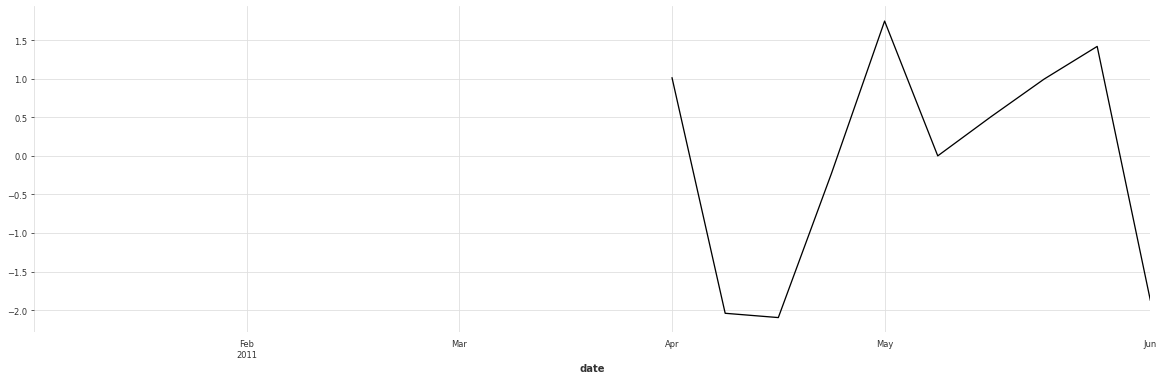

In [93]:
train['Change Seasonal First Difference'].plot()

<AxesSubplot:xlabel='date'>

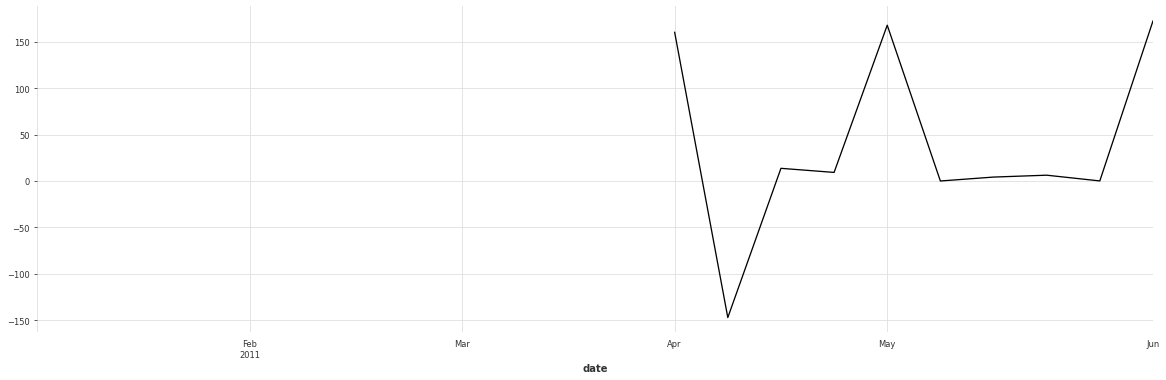

In [94]:
train['Open Seasonal First Difference'].plot()

<AxesSubplot:xlabel='date'>

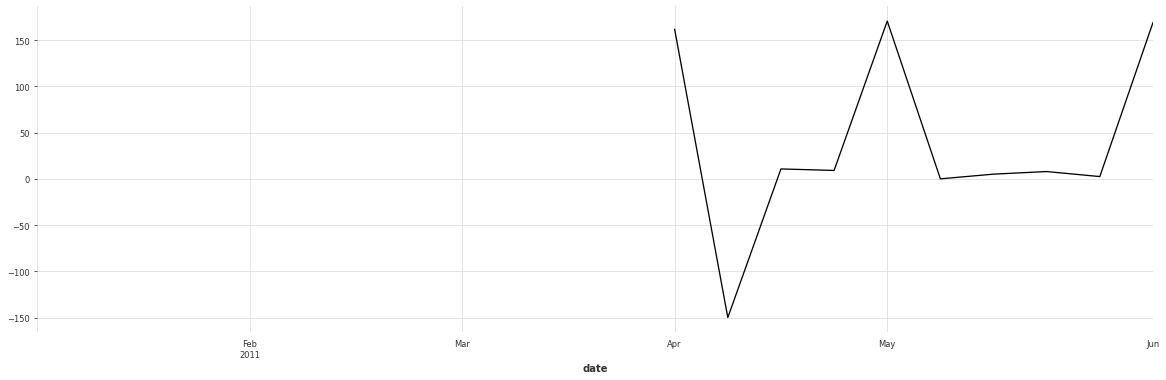

In [95]:
train['Close Seasonal First Difference'].plot()

In [96]:
from pandas.plotting import autocorrelation_plot


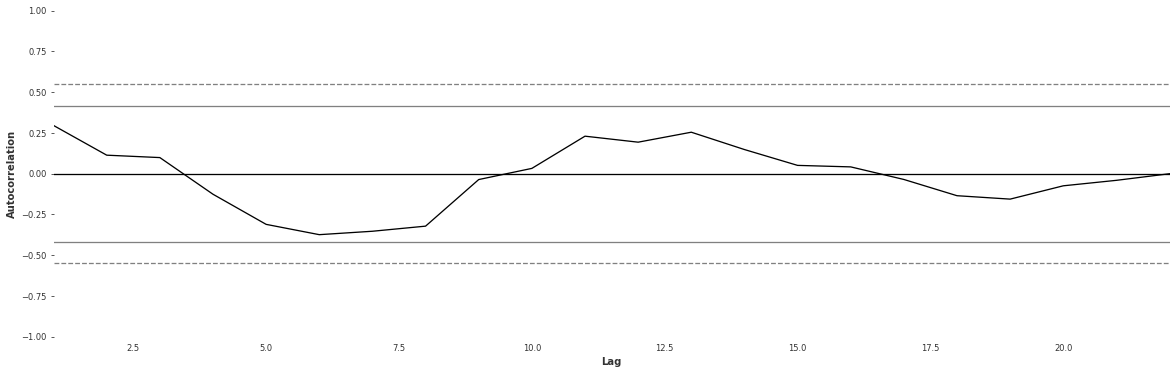

In [97]:
autocorrelation_plot(train['percent_change_price'])
plt.show()

In [82]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['percent_change_price'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     percent_change_price   No. Observations:                   22
Model:                   ARIMA(1, 1, 1)   Log Likelihood                 -41.738
Date:                  Thu, 18 Aug 2022   AIC                             89.477
Time:                          22:49:50   BIC                             92.610
Sample:                      01-09-2011   HQIC                            90.157
                           - 06-05-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3861      0.441      0.875      0.381      -0.478       1.251
ma.L1         -0.9993     40.075     -0.025      0.980     -79.545      77.547
sigma2         2.7921    110.890      0.025      0.980    -214.549     220.133
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.60   Prob(JB):                         0.64
Heteroskedasticity (H):               0.73   Skew:                             0.46
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

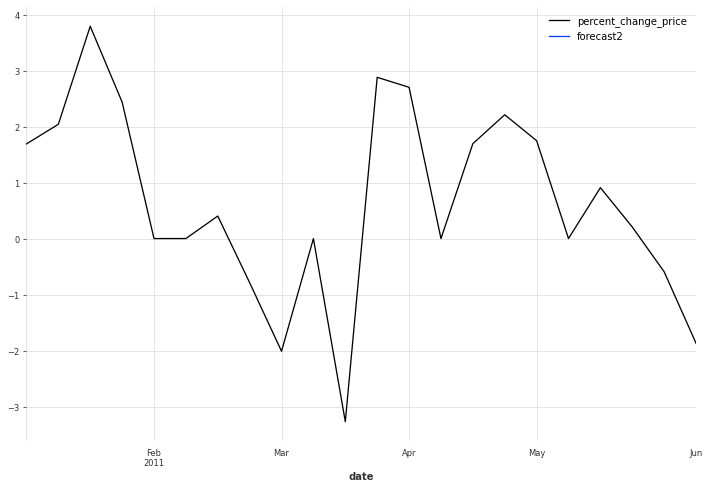

In [98]:
train['forecast2']=model_fit.predict(start=90,end=103,dynamic=True)
train[['percent_change_price','forecast2']].plot(figsize=(12,8))

In [80]:

model=ARIMA(train['close'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                   22
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -123.766
Date:                Thu, 18 Aug 2022   AIC                            253.533
Time:                        22:48:47   BIC                            256.666
Sample:                    01-09-2011   HQIC                           254.213
                         - 06-05-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1070      0.328     -0.326      0.744      -0.750       0.536
ma.L1         -0.9990     40.499     -0.025      0.980     -80.376      78.378
sigma2      6597.4794   2.67e+05      0.025      0.980   -5.16e+05    5.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.80   Prob(JB):                         0.94
Heteroskedasticity (H):               0.63   Skew:                            -0.15
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:

model=ARIMA(train['open'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   open   No. Observations:                   22
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -123.565
Date:                Thu, 18 Aug 2022   AIC                            253.130
Time:                        22:49:13   BIC                            256.263
Sample:                    01-09-2011   HQIC                           253.810
                         - 06-05-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1149      0.329     -0.350      0.727      -0.759       0.529
ma.L1         -0.9991     43.669     -0.023      0.982     -86.588      84.590
sigma2      6467.1903   2.82e+05      0.023      0.982   -5.46e+05    5.59e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.80   Prob(JB):                         0.94
Heteroskedasticity (H):               0.64   Skew:                            -0.16
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38899D-01    |proj g|=  2.57817D-01

At iterate    5    f=  7.89707D-01    |proj g|=  2.80049D-02

At iterate   10    f=  7.82071D-01    |proj g|=  3.81418D-03

At iterate   15    f=  7.81246D-01    |proj g|=  2.53031D-03

At iterate   20    f=  7.81146D-01    |proj g|=  5.26943D-03

At iterate   25    f=  7.81114D-01    |proj g|=  3.88955D-03

At iterate   30    f=  7.81097D-01    |proj g|=  2.01145D-03

At iterate   35    f=  7.81085D-01    |proj g|=  1.06569D-04

At iterate   40    f=  7.81077D-01    |proj g|=  7.44791D-04


 This problem is unconstrained.



At iterate   45    f=  7.81072D-01    |proj g|=  4.17906D-03

At iterate   50    f=  7.81066D-01    |proj g|=  1.90742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   1.907D-03   7.811D-01
  F =  0.78106551076556707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<AxesSubplot:xlabel='date'>

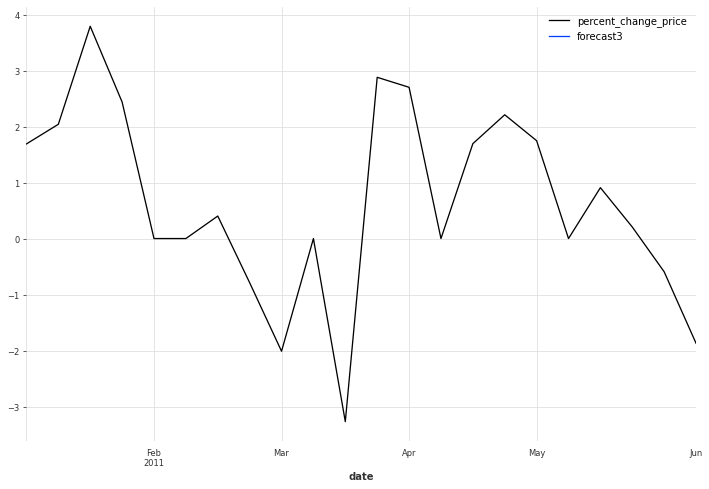

In [99]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(train['percent_change_price'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
train['forecast3']=results.predict(start=90,end=103,dynamic=True)
train[['percent_change_price','forecast3']].plot(figsize=(12,8))

<AxesSubplot:>

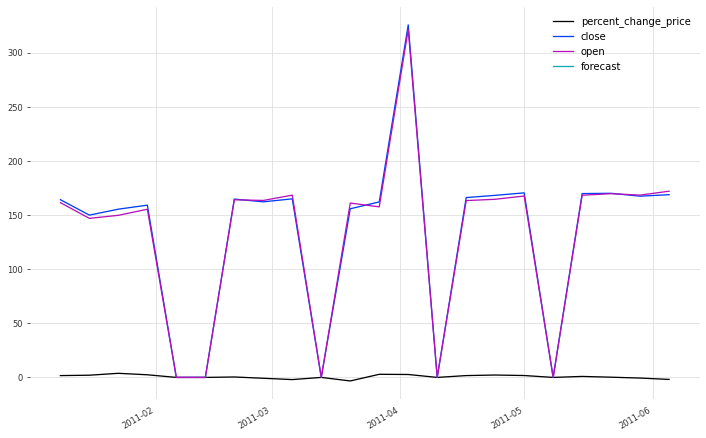

In [92]:
from pandas.tseries.offsets import DateOffset
future_dates=[train.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=train.columns)

future_datest_df.tail()

future_df=pd.concat([train,future_datest_df])

future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)
future_df[['percent_change_price', 'close', 'open', 'forecast']].plot(figsize=(12, 8))